In [1]:
from math import pi
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit.circuit.library import QFTGate
from qiskit.circuit.library import RGQFTMultiplier
from qiskit.quantum_info import Statevector
from qiskit import transpile

# Part A
## Auxiliary blocks

C:\Users\cpawl\AppData\Local\Temp\ipykernel_17804\2443207912.py:12: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_qubits=4,do_swaps=True, inverse=False), [0, 1, 2, 3])
C:\Users\cpawl\AppData\Local\Temp\ipykernel_17804\2443207912.py:20: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_qubits=4,do_swaps=True, inverse=True), [0, 1, 2, 3])


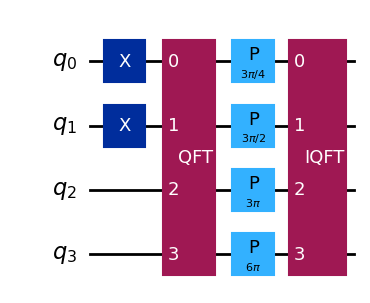

In [7]:
qc = QuantumCircuit(4)

# Set bit value for 3
qc.x(0)
qc.x(1)

qc_input = QuantumCircuit(4)
qc_input.x(0)
qc_input.x(1)

# QFT
qc.append(QFT(num_qubits=4,do_swaps=True, inverse=False), [0, 1, 2, 3])

# Rn gates (Sum(k) from the paper)
angle = 2*pi*6
for i in range(4):
    qc.p(angle / (2 ** (i+1)), 3-i)

# IQFT
qc.append(QFT(num_qubits=4,do_swaps=True, inverse=True), [0, 1, 2, 3])
qc.draw('mpl')

In [8]:
psi = Statevector(qc)
psi.draw("latex") 

<IPython.core.display.Latex object>

#### Input: |0011> = |3>
#### k = 6
#### Output: |1001> = |9>

---
# Part B
## Inplace modular quantum–classical adder Addin(k,N)

#### Auxiliary qubits have been moved to the bottom for coding convenience

C:\Users\cpawl\AppData\Local\Temp\ipykernel_37132\2084342036.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=False).to_gate()
C:\Users\cpawl\AppData\Local\Temp\ipykernel_37132\2084342036.py:3: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=True).to_gate()


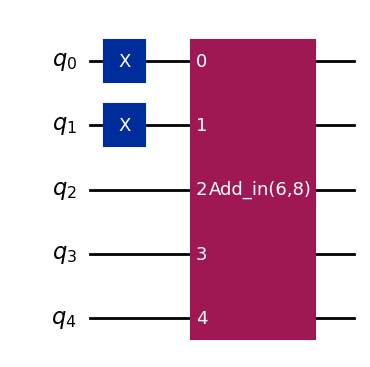

In [2]:
def inplace_QC_adder(k, N, n_bits):
    qft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=False).to_gate()
    iqft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=True).to_gate()
    
    qc = QuantumCircuit(n_bits+2, name=f'Add_in({k},{N})')
    
    # QFT
    qc.append(qft_gate, range(n_bits+1))
    
    # Rn gates (Sum(k) from the paper)
    angle = 2*pi*k
    for i in range(n_bits+1):
        qc.p(angle / (2 ** (i+1)), n_bits-i)
        
    # Rn gates (Sum(-N) from the paper)
    angle = 2*pi*-N
    for i in range(n_bits+1):
        qc.p(angle / (2 ** (i+1)), n_bits-i)
    
    # IQFT
    qc.append(iqft_gate, range(n_bits+1))
    
    # CNOT onto auxilary wire
    qc.cx(-2, -1, ctrl_state='1')
    
    # QFT
    qc.append(qft_gate, range(n_bits+1))
    
    # Controlled-Rn gates (Sum(N) from the paper)
    angle = 2*pi*N
    for i in range(n_bits+1):
        qc.cp(angle / (2 ** (i+1)), n_bits-i, -1)
        
    # Rn gates (Sum(-k) from the paper)
    angle = 2*pi*-k
    for i in range(n_bits+1):
        qc.p(angle / (2 ** (i+1)), n_bits-i)
    
    # IQFT
    qc.append(iqft_gate, range(n_bits+1))
    
    # CNOT onto auxilary wire
    qc.cx(-2, -1, ctrl_state='0')
    
    # QFT
    qc.append(qft_gate, range(n_bits+1))
    
    # Controlled-Rn gates (Sum(k) from the paper)
    angle = 2*pi*k
    for i in range(n_bits+1):
        qc.p(angle / (2 ** (i+1)), n_bits-i)
    
    # IQFT
    qc.append(iqft_gate, range(n_bits+1))

    # Return the circuit
    return qc


qc2 = QuantumCircuit(5)
# Set initial bit value for a
temp = 3
i = 0
while (temp > 0):
    if (temp % 2 == 1):
        qc2.x(i)
        temp = temp - 1
    temp = temp / 2
    i = i + 1

qc2.append(inplace_QC_adder(6, 8, 3), [0, 1, 2, 3, 4])
qc2.draw('mpl')

In [10]:
psi2 = Statevector(qc2)
psi2.draw("latex") 

<IPython.core.display.Latex object>

#### Input: |00011> = |00>|3>
#### k = 6, N = 8
#### Output: |00001> = |00>|1>

---
# Part C
## Outplace modular quantum–classical adder Addout(k,N)

C:\Users\cpawl\AppData\Local\Temp\ipykernel_17804\2084342036.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=False).to_gate()
C:\Users\cpawl\AppData\Local\Temp\ipykernel_17804\2084342036.py:3: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=True).to_gate()


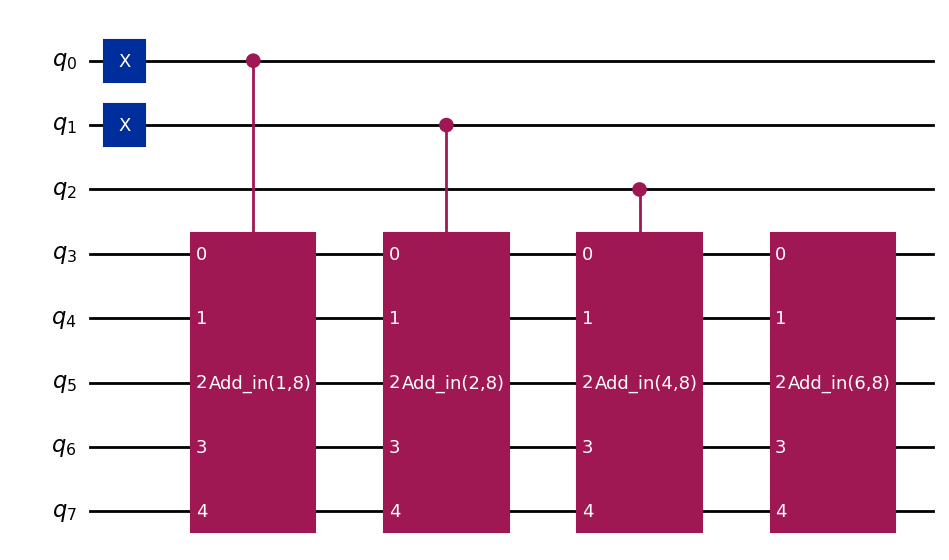

In [11]:
# New circuit with 3 qubits for a and 5 auxiliary qubits
qc3 = QuantumCircuit(8)
qc3.x(0)
qc3.x(1)

qc3.append(inplace_QC_adder(2**0, 8, 3).to_gate().control(1), [0, 3, 4, 5, 6, 7])
qc3.append(inplace_QC_adder(2**1, 8, 3).to_gate().control(1), [1, 3, 4, 5, 6, 7])
qc3.append(inplace_QC_adder(2**2, 8, 3).to_gate().control(1), [2, 3, 4, 5, 6, 7])
qc3.append(inplace_QC_adder(6, 8, 3), [3, 4, 5, 6, 7]) # AddIn(k)
qc3.draw('mpl')

In [12]:
psi3 = Statevector(qc3)
psi3.draw("latex")

<IPython.core.display.Latex object>

#### Input: |00000011> = |00>|0>|3>
#### k = 6, N=8
#### Output: |00001011> = |00>|1>|3>

---
# Part D
## Inplace modular quantum–quantum adder Addin(N)

C:\Users\cpawl\AppData\Local\Temp\ipykernel_17804\2084342036.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=False).to_gate()
C:\Users\cpawl\AppData\Local\Temp\ipykernel_17804\2084342036.py:3: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=True).to_gate()


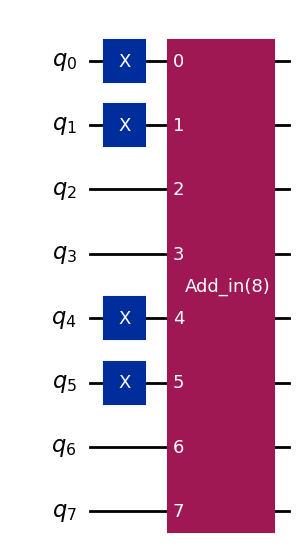

In [13]:
def inplace_QQ_adder(N, a_bits, b_bits):
    # Find total bits needed
    total_bits = a_bits + b_bits + 2
    # New circuit with 3 qubits for a and 5 auxiliary qubits
    qc = QuantumCircuit(total_bits, name=f'Add_in({N})')
    
    # Add controlled adder gates
    for i in range(a_bits):
        l = [i]
        l.extend(list(range(a_bits, a_bits + b_bits + 2)))
        qc.append(inplace_QC_adder(2**i, N, b_bits).to_gate().control(1), l)

    return qc

qc4 = QuantumCircuit(8)
# Set the a bits to 3
qc4.x(0)
qc4.x(1)
# set the b bits to 6
qc4.x(4)
qc4.x(5)
qc4.append(inplace_QQ_adder(8, 3, 3), range(8))
qc4.draw('mpl')

In [14]:
psi4 = Statevector(qc4)
psi4.draw("latex")

<IPython.core.display.Latex object>

#### Input: |00110011> = |00>|6>|3>
#### N = 8
#### Output: |00001011> = |00>|1>|3>

---
# Part E
## Outplace modular quantum–quantum adder Addout(N)

C:\Users\cpawl\AppData\Local\Temp\ipykernel_17804\2084342036.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=False).to_gate()
C:\Users\cpawl\AppData\Local\Temp\ipykernel_17804\2084342036.py:3: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=True).to_gate()


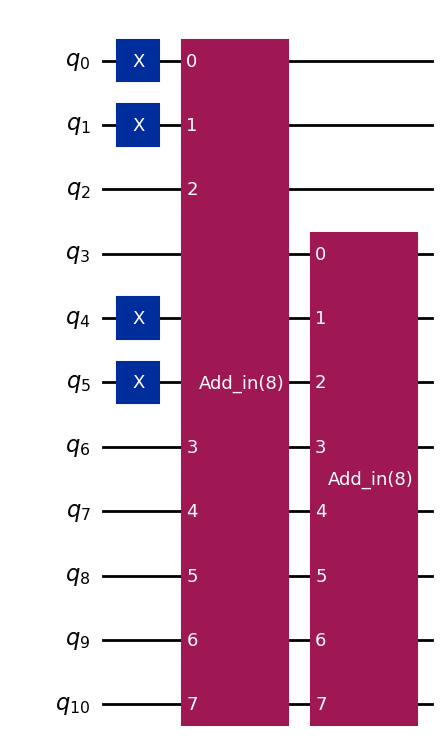

In [15]:
# New circuit with 3 qubits for a and 5 auxiliary qubits
qc5 = QuantumCircuit(11)
# Set the a bits to 3
qc5.x(0)
qc5.x(1)
# set the b bits to 6
qc5.x(4)
qc5.x(5)

# Add controlled adder gates
qc5.append(inplace_QQ_adder(8, 3, 3), [0, 1, 2, 6, 7, 8, 9, 10])
qc5.append(inplace_QQ_adder(8, 3, 3), [3, 4, 5, 6, 7, 8, 9, 10])
qc5.draw('mpl')

In [16]:
psi5 = Statevector(qc5)
psi5.draw("latex")

<IPython.core.display.Latex object>

#### Input: |00000110011> = |00>|0>|6>|3>
#### N = 8
#### Output: |00001110011> = |00>|1>|6>|3>

---
# Part F
## Outplace modular quantum–classical multiplier Multout(k,N)

C:\Users\cpawl\AppData\Local\Temp\ipykernel_37132\2084342036.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=False).to_gate()
C:\Users\cpawl\AppData\Local\Temp\ipykernel_37132\2084342036.py:3: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=True).to_gate()


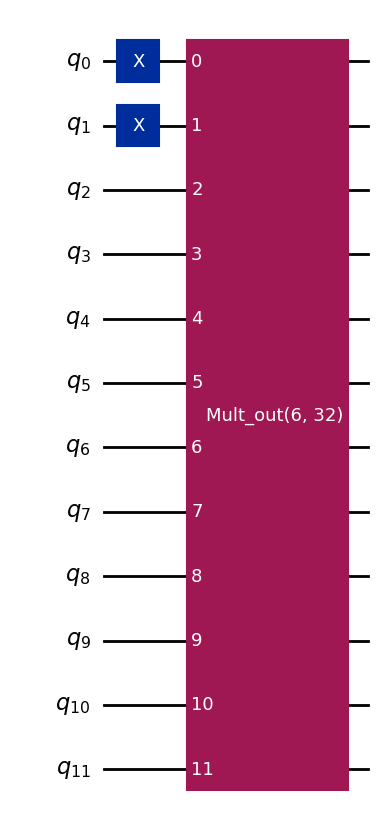

In [3]:
def outplace_QC_mult(k, N, a_bits, b_bits):
    # Make the circuit
    total_bits = a_bits + b_bits + 2
    qc = QuantumCircuit(total_bits, name=f'Mult_out({k}, {N})')

    # Add controlled adder gates
    for i in range(a_bits):
        l = [i]
        l.extend(list(range(a_bits, a_bits + b_bits + 2)))
        qc.append(inplace_QC_adder(k*2**i, N, b_bits).to_gate().control(1), l)

    return qc

# New circuit with 5 qubits for a and 7 auxiliary qubits (5 for b and 2 extra)
qc6 = QuantumCircuit(12)
# Set the a bits to 3
qc6.x(0)
qc6.x(1)

# Add controlled adder gates
qc6.append(outplace_QC_mult(6, 32, 5, 5), range(12))
qc6.draw('mpl')

In [18]:
psi6 = Statevector(qc6)
psi6.draw("latex")

<IPython.core.display.Latex object>

#### Input: |000000000011> = |00>|0>|3>
#### k = 6, N = 32
#### Output: |001001000011> = |00>|18>|3>

---
# Part G
## Inplace modular quantum–classical multiplier Multin(k,N)

C:\Users\cpawl\AppData\Local\Temp\ipykernel_37132\2084342036.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=False).to_gate()
C:\Users\cpawl\AppData\Local\Temp\ipykernel_37132\2084342036.py:3: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=True).to_gate()


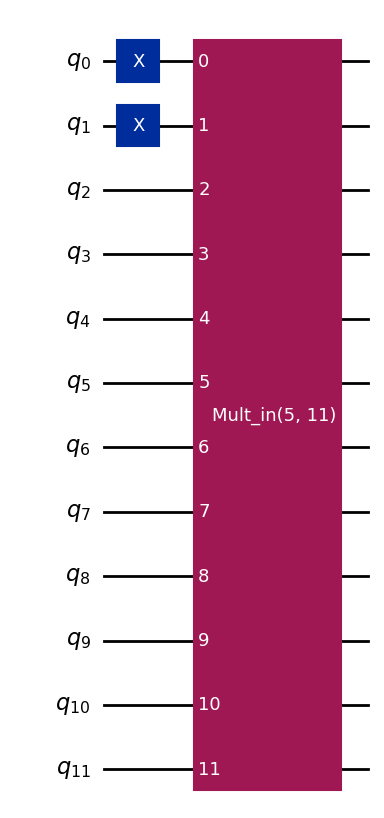

In [4]:
# Calculating the modular inverse is complicated
# To make things easier, N must be prime, and k must have a modular inverse in N
def inplace_QC_mult(k, N, a_bits, aux_bits):
    # Make the circuit
    total_bits = a_bits + aux_bits + 2
    qc = QuantumCircuit(total_bits, name=f'Mult_in({k}, {N})')

    # Add the first Mult_out
    qc.append(outplace_QC_mult(k, N, a_bits, aux_bits).to_gate(), range(total_bits))
    
    # Add the swap gates
    for i in range(a_bits):
        qc.swap(i, i+a_bits)

    # Calculate the modular inverse for k
    inverse = pow(k, N-2, N)
    
    # Add the second Mult_out
    qc.append(outplace_QC_mult(N - inverse, N, a_bits, aux_bits).to_gate(), range(total_bits))
    
    return qc

# New circuit with 5 qubits for a and 7 auxiliary qubits (5 for b and 2 extra)
qc6 = QuantumCircuit(12)
# Set the a bits to 3
qc6.x(0)
qc6.x(1)

# Add mult gates
qc6.append(inplace_QC_mult(5, 11, 5, 5), range(12))
qc6.draw('mpl')

In [20]:
psi6 = Statevector(qc6)
psi6.draw("latex")

<IPython.core.display.Latex object>

#### Input: |000000000011> = |00>|0>|3>
#### k = 5, N = 11
#### Output: |000000000100> = |00>|0>|4>

---
# Part H
## Outplace modular quantum–quantum multiplier Multout(N)

C:\Users\cpawl\AppData\Local\Temp\ipykernel_37132\2084342036.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=False).to_gate()
C:\Users\cpawl\AppData\Local\Temp\ipykernel_37132\2084342036.py:3: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=True).to_gate()


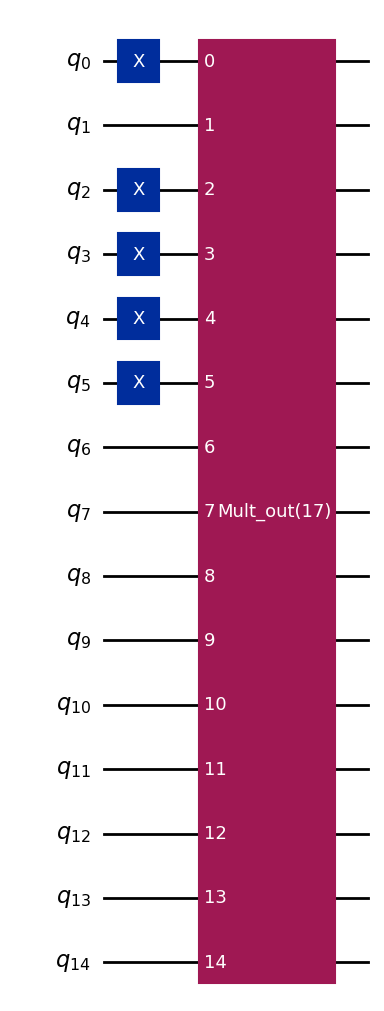

In [32]:
def outplace_QQ_mult(N, a_bits, b_bits, aux_bits):
    # Make the circuit
    total_bits = a_bits + b_bits + aux_bits + 2
    qc = QuantumCircuit(total_bits, name=f'Mult_out({N})')

    for i in range(a_bits):
        l = [i]
        l.extend(list(range(a_bits, total_bits)))
        qc.append(outplace_QC_mult(2**i, N, b_bits, aux_bits).to_gate().control(1), l)
    
    return qc

# New circuit with 3 qubits for a, 5 qubits for b and 7 auxiliary qubits
qc7 = QuantumCircuit(15)
# Set the a bits to 5
qc7.x(0)
qc7.x(2)
# Set the b bits to 7
qc7.x(3)
qc7.x(4)
qc7.x(5)

# Add controlled mult gates
qc7.append(outplace_QQ_mult(17, 3, 5, 5), range(15))
qc7.draw('mpl')

In [33]:
psi7 = Statevector(qc7)
psi7.draw("latex")

<IPython.core.display.Latex object>

#### Input: |000000000111101> = |00>|0>|7>|5>
#### N = 17
#### Output: |000000100111101> = |00>|1>|7>|5>

---
# Part I is skipped because the quantum inverse operation is unknown

---
# Part J
## Outplace modular exponentiation Exp(a,N)

C:\Users\cpawl\AppData\Local\Temp\ipykernel_37132\2084342036.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=False).to_gate()
C:\Users\cpawl\AppData\Local\Temp\ipykernel_37132\2084342036.py:3: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(num_qubits=n_bits+1, do_swaps=True, inverse=True).to_gate()


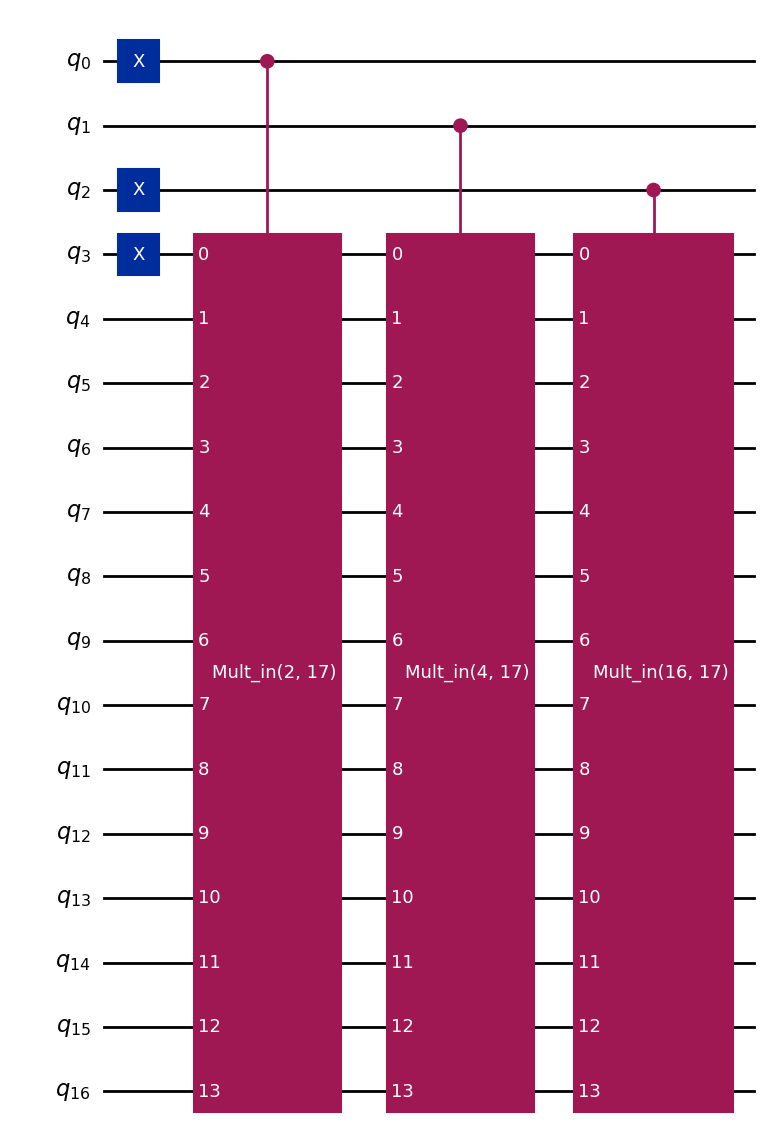

In [5]:
# New circuit with 3 qubits for x, 6 qubits for the target wires and 8 auxiliary qubits
qc8 = QuantumCircuit(17)
# Set the a bits to 5
qc8.x(0)
qc8.x(2)
# Set the target bits to 1
qc8.x(3)

a = 2
N = 17

for i in range(3): # 3 bits for x
    # Make list of target qubits
    l = [i]
    l.extend(list(range(3, 17)))

    # Calculate a^2^i
    val = a ** (2**i)

    # Add MultIn circuit
    qc8.append(inplace_QC_mult(val, N, 6, 6).to_gate().control(1), l)


qc8.draw('mpl')

In [6]:
psi8 = Statevector(qc8)
psi8.draw("latex")

<IPython.core.display.Latex object>

#### Input: |00000000000001101> = |00>|0>|1>|5>
#### a = 2, N = 17
#### Output: |00000000001111101> = |00>|0>|15>|5>

---
# Part 2

### IMPORTANT:
#### It was very difficult to figure out how to make an exponential operator with the provided methods. After days of deliberation, I was able to find solutions that required so many qubits that the circuits would require thousands of times more memory that any computer has available. After cutting down the number of qubits as much as possible, this is what remains.

#### The circuit requires multiple auxiliary registers that do not get cleared, because clearing them would require following the equations in part I of the research paper, which was deemed not feasible due to the inverse of a being needed.

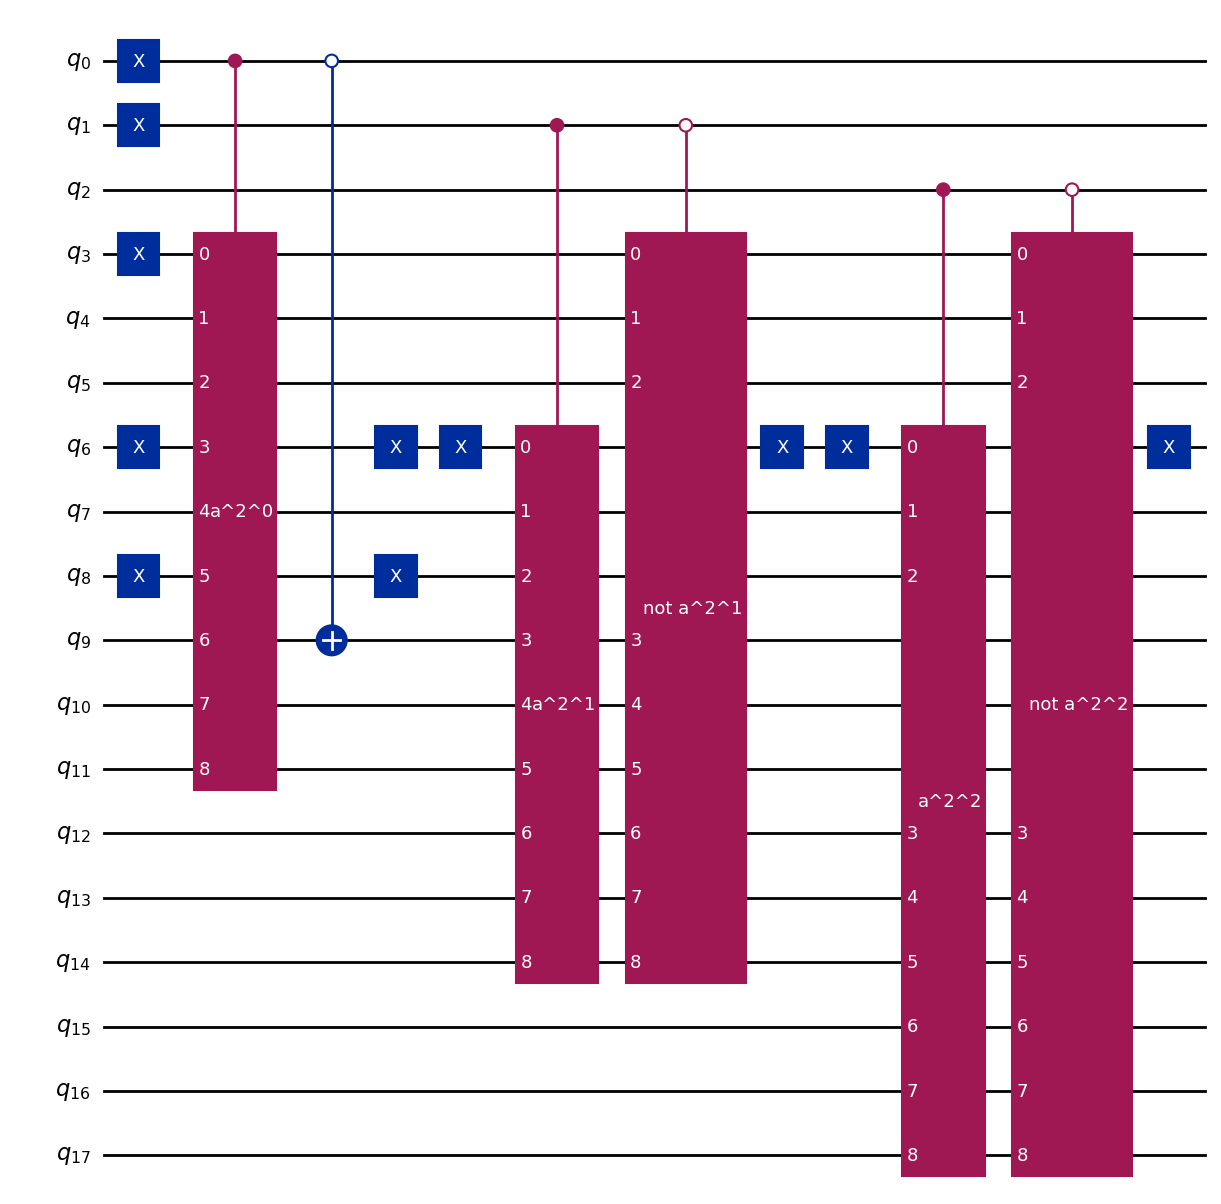

In [27]:
# 3 for x, 3 for 1, 3 for a-a^4, 6 for output steps, 3 for final output
qc_exp = QuantumCircuit(18)

# Set values
# x = 3
qc_exp.x(0)
qc_exp.x(1)
# set 1 register (q3-q5)
qc_exp.x(3)

a = 5
for i in range(3):
    val = (a ** (2**i))%32

    # Encode a, a^2, a^4 (q6-q8)
    num = val
    for j in range(3):
        if num % 2 == 1:
            qc_exp.x(6 + j)
            num -= 1
        num /= 2

    if i == 0:
        qc_exp.append(RGQFTMultiplier(3, 3, name='a^2^0').to_gate().control(1, ctrl_state='1'), [0, 3,4,5, 6,7,8, 9,10,11])
        qc_exp.cx(0, 9, ctrl_state='0') # set register to 1 if control is 0
    if i == 1:
        qc_exp.append(RGQFTMultiplier(3, 3, name='a^2^1').to_gate().control(1, ctrl_state='1'), [1, 6,7,8, 9,10,11, 12,13,14])
        qc_exp.append(RGQFTMultiplier(3, 3, name='not a^2^1').to_gate().control(1, ctrl_state='0'), [1, 3,4,5, 9,10,11, 12,13,14])
    if i == 2:     
        qc_exp.append(RGQFTMultiplier(3, 3, name='a^2^2').to_gate().control(1, ctrl_state='1'), [2, 6,7,8, 12,13,14, 15,16,17])
        qc_exp.append(RGQFTMultiplier(3, 3, name='not a^2^2').to_gate().control(1, ctrl_state='0'), [2, 3,4,5, 12,13,14, 15,16,17])

    # Reset encoded value
    num = val
    for j in range(3):
        if num % 2 == 1:
            qc_exp.x(6 + j)
            num -= 1
        num /= 2

qc_exp.draw('mpl')

In [28]:
psi_exp = Statevector(qc_exp)
psi_exp.draw("latex")

<IPython.core.display.Latex object>

#### The circuit calculated 5^3 mod 8, which got stored into the final register (q15-q17) on the far left. The final value is 5, as expected.

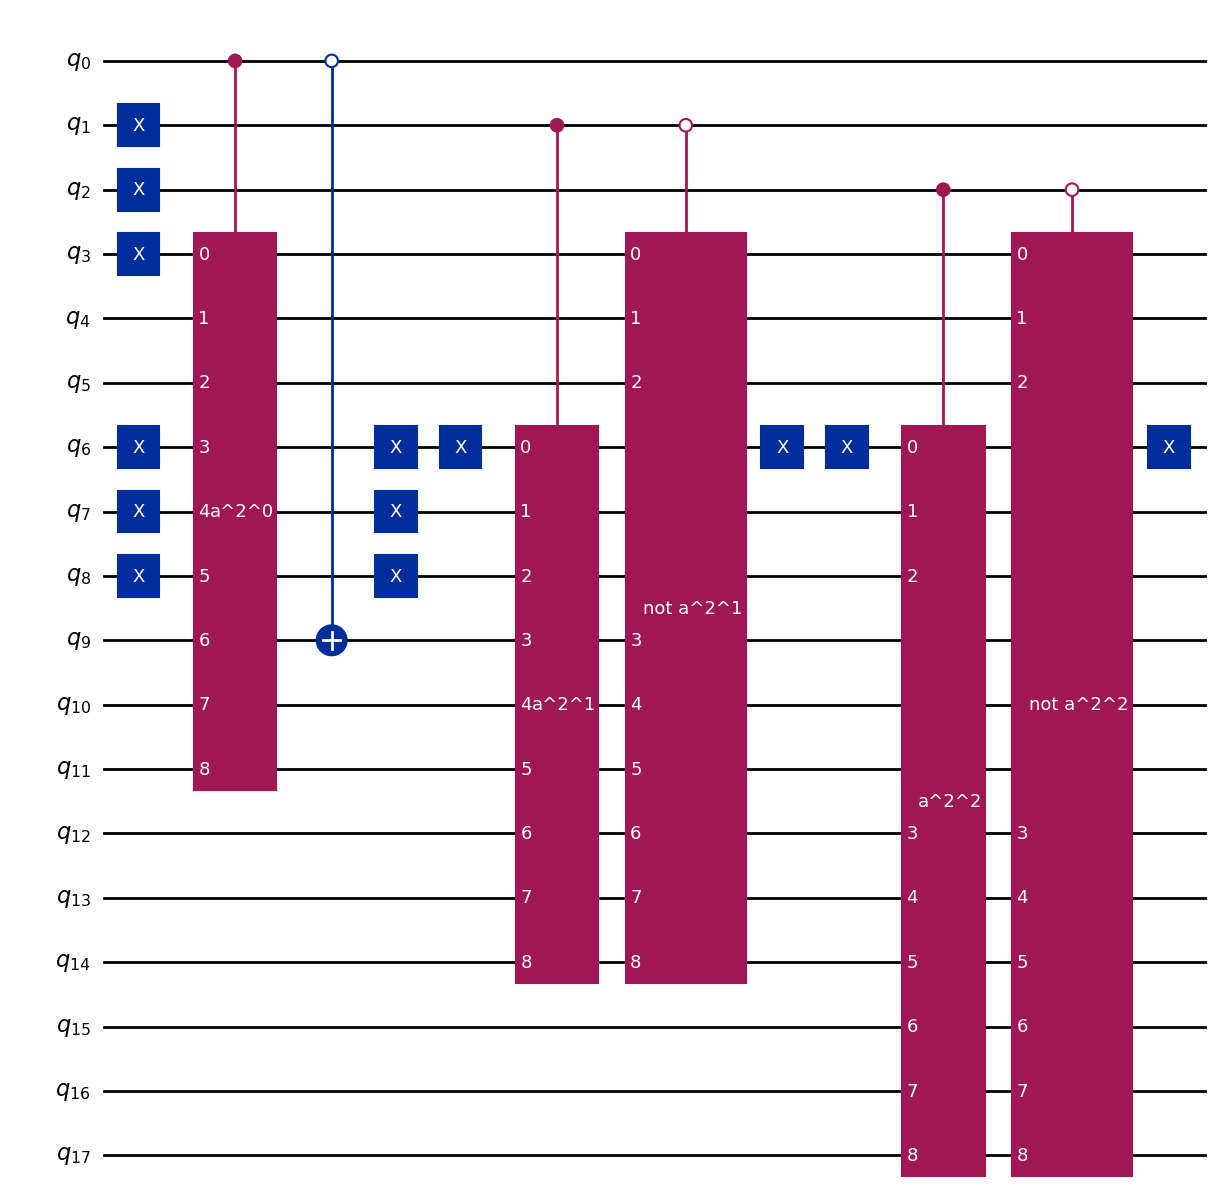

In [29]:
# 3 for x, 3 for 1, 3 for a-a^4, 6 for output steps, 3 for final output
qc_exp2 = QuantumCircuit(18)

# Set values
# x = 6
qc_exp2.x(1)
qc_exp2.x(2)
# set 1 register (q3-q5)
qc_exp2.x(3)

a = 7
for i in range(3):
    val = (a ** (2**i))%32

    # Encode a, a^2, a^4 (q6-q8)
    num = val
    for j in range(3):
        if num % 2 == 1:
            qc_exp2.x(6 + j)
            num -= 1
        num /= 2

    if i == 0:
        qc_exp2.append(RGQFTMultiplier(3, 3, name='a^2^0').to_gate().control(1, ctrl_state='1'), [0, 3,4,5, 6,7,8, 9,10,11])
        qc_exp2.cx(0, 9, ctrl_state='0') # set register to 1 if control is 0
    if i == 1:
        qc_exp2.append(RGQFTMultiplier(3, 3, name='a^2^1').to_gate().control(1, ctrl_state='1'), [1, 6,7,8, 9,10,11, 12,13,14])
        qc_exp2.append(RGQFTMultiplier(3, 3, name='not a^2^1').to_gate().control(1, ctrl_state='0'), [1, 3,4,5, 9,10,11, 12,13,14])
    if i == 2:     
        qc_exp2.append(RGQFTMultiplier(3, 3, name='a^2^2').to_gate().control(1, ctrl_state='1'), [2, 6,7,8, 12,13,14, 15,16,17])
        qc_exp2.append(RGQFTMultiplier(3, 3, name='not a^2^2').to_gate().control(1, ctrl_state='0'), [2, 3,4,5, 12,13,14, 15,16,17])

    # Reset encoded value
    num = val
    for j in range(3):
        if num % 2 == 1:
            qc_exp2.x(6 + j)
            num -= 1
        num /= 2

qc_exp2.draw('mpl')

In [30]:
psi_exp2 = Statevector(qc_exp2)
psi_exp2.draw("latex")

<IPython.core.display.Latex object>

#### The circuit calculated 7^6 mod 8, which got stored into the final register (q15-q17) on the far left. The final value is 1, as expected.
---
#### Now, we find the size information for both exponential circuits

In [9]:
result_part1 = transpile(qc8, basis_gates=['rx','rz','ry','cx'])

circuit_depth1 = result_part1.depth()
circuit_width1 = result_part1.width()

print("Circuit Depth:", circuit_depth1)
print("Circuit Width:", circuit_width1)
print(dict(result_part1.count_ops()))

Circuit Depth: 1705962
Circuit Width: 17
{'rz': 987797, 'cx': 813032, 'ry': 328865, 'rx': 80887}


In [31]:
result_part2 = transpile(qc_exp, basis_gates=['rx','rz','ry','cx'])

circuit_depth2 = result_part2.depth()
circuit_width2 = result_part2.width()

print("Circuit Depth:", circuit_depth2)
print("Circuit Width:", circuit_width2)
print(dict(result_part2.count_ops()))

Circuit Depth: 11949
Circuit Width: 18
{'rz': 7160, 'cx': 6299, 'ry': 2103, 'rx': 934}


#### The modular exponentiation circuit in part A is very large compared to part B. With a similar width between them (17 vs. 18 qubits), the depth of circuit A is 142x larger, with the gate counts ranging from 86x larger, to 156x larger.
#### This difference in gate count can be felt by the difference in time it takes to run the statevectors for each circuit. However, the circuit in part A is much more powerful, as it can calculate exponents with a modulus of up to 32, while part B can only have a mod 8.